# LIBRARIES

In [666]:
!nvidia-smi

Tue Nov 24 16:16:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    25W /  75W |   7355MiB /  7611MiB |     33%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [667]:

import warnings
warnings.simplefilter('ignore')

# for Colab link with Drive
from google.colab import drive


from zipfile import ZipFile


import os

import cv2 

import math
import random
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D,AveragePooling2D, BatchNormalization,MaxPooling2D,ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

# others ibraries
from tqdm.notebook import tqdm 

from matplotlib import pyplot as plt

In [668]:
SEED = 100

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [669]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPROCESSING

In [652]:
PATH = \
{
    "CSV" : os.path.join( "ADRA", "CSV",  ),
    "IMAGES" : os.path.join( "ADRA", "IMAGES",  ),
    "train" : os.path.join( "ADRA", "IMAGES", "xrays database"),
    "test" : os.path.join( "test","test_dataset"),
    "1ROOT" : os.path.join( "ADRA", "IMAGES","xrays database", "1 root”" ),
    "MULTIPLE ROOTS" : os.path.join( "ADRA", "IMAGES","xrays database", "2 or more roots" ),
  
} 


In [653]:
def unzip():
    print(f"[INFO] Unzipping file ")
    with ZipFile("/content/drive/MyDrive/AdraAssignment/xrays database-20201119T170209Z-001.zip", 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(PATH['IMAGES'])
    print(f"[INFO] Succesful unzip file")
# unzip()

def build_dataset():
    unzip()
    for folder in [os.path.join(PATH['train'], "1 root"),
            os.path.join(PATH['train'], "2 or more roots")]:

        n_imgs = len(os.listdir( folder ))
        print( f"[INFO] '{n_imgs}' in folder '{folder}' " )

In [654]:
build_dataset()

[INFO] Unzipping file 
[INFO] Succesful unzip file
[INFO] '66' in folder 'ADRA/IMAGES/xrays database/1 root' 
[INFO] '50' in folder 'ADRA/IMAGES/xrays database/2 or more roots' 


In [655]:
def get_dataset():

    data = []

    for dirname, _, filenames in tqdm( os.walk(PATH['IMAGES']) ):
        for filename in filenames:
            if filename.endswith('.jpg')==True:
                
                filepath = os.path.join(dirname, filename)
                target = os.path.split(dirname)[-1]
                data += [{'image' : filename, 'filepath' : filepath, 'target' : target  }]
    
    return pd.DataFrame(data)

In [656]:
train_df = get_dataset()
train_df 

,image,filepath,target
0,tooth96.jpg,ADRA/IMAGES/xrays database/2 or more roots/too...,2 or more roots
1,tooth1.jpg,ADRA/IMAGES/xrays database/2 or more roots/too...,2 or more roots
2,tooth109.jpg,ADRA/IMAGES/xrays database/2 or more roots/too...,2 or more roots
3,tooth70.jpg,ADRA/IMAGES/xrays database/2 or more roots/too...,2 or more roots
4,tooth49.jpg,ADRA/IMAGES/xrays database/2 or more roots/too...,2 or more roots
...,...,...,...
110,tooth29.jpg,ADRA/IMAGES/xrays database/1 root/tooth29.jpg,1 root
111,tooth78.jpg,ADRA/IMAGES/xrays database/1 root/tooth78.jpg,1 root
112,tooth84.jpg,ADRA/IMAGES/xrays database/1 root/tooth84.jpg,1 root
113,tooth72.jpg,ADRA/IMAGES/xrays database/1 root/tooth72.jpg,1 root


In [657]:
classes = train_df .target.unique().tolist()

1 root             65
2 or more roots    50
Name: target, dtype: int64


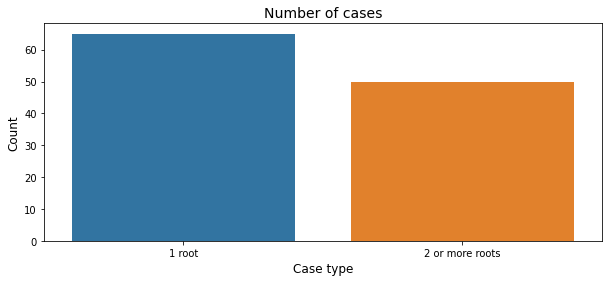

In [658]:
cases_count = train_df ['target'].value_counts()
print(cases_count)


# Plot the results 
plt.figure(figsize=(10,4))
sb.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['1 root', '2 or more roots'])
plt.show()

# DATA VISUALIZATION

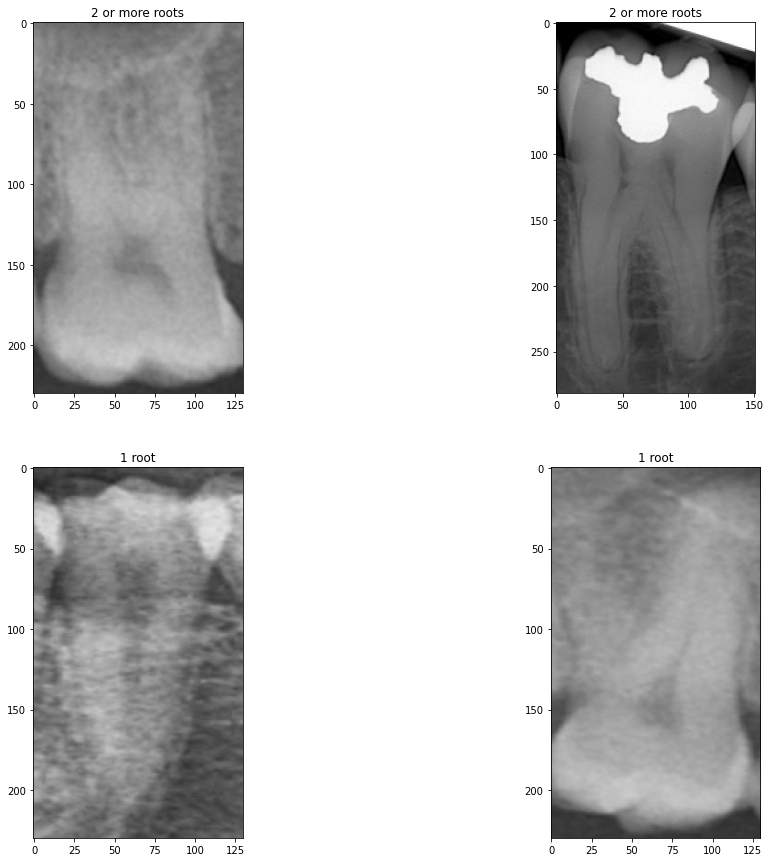

In [659]:
nrows = 2
rands = np.random.randint(train_df.shape[0], size=nrows**2)

fig = plt.figure(figsize=(17,15))

for i in range(nrows**2):
    img = cv2.imread(train_df.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train_df.loc[rands[i], 'target'])
plt.show()

# IMAGE AUGUMENTATION

In [660]:
image_path=PATH['train']
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
train_generator = datagen.flow_from_directory(image_path,
                                                    batch_size=115,
                                                    class_mode='binary',
                                                    target_size=(224, 224),
                                                    subset='training')
val_generator = datagen.flow_from_directory(image_path,
                                            batch_size=115,
                                            class_mode='binary',
                                            target_size=(224, 224),
                                            subset='validation')



Found 92 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [661]:
train_generator.image_shape

(224, 224, 3)

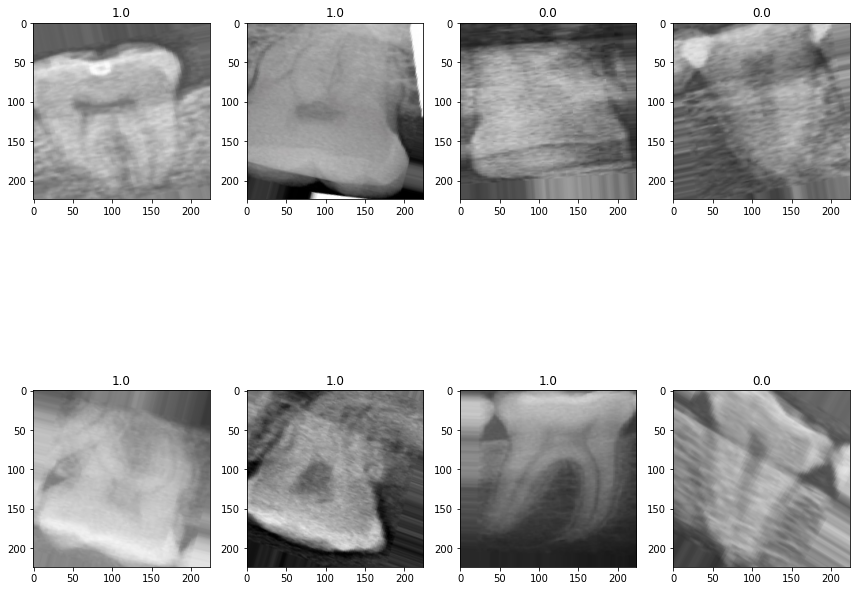

In [662]:
#  VISUALIZE THE TRANSFORMED IMAGES
plt.figure(figsize=(12, 12))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.title(Y_batch[0])
        break
plt.tight_layout()
plt.show()

# TRANSFER LEARNING MODEL

In [663]:
# USING THE INCEPTIONV3 PRE-TRAINED MODEL
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1200, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

model2 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [664]:
model2.compile(optimizer = RMSprop(lr=1e-4), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [665]:
EPOCHS=20
history2 = model2.fit(train_generator,
                              epochs=EPOCHS,
                              verbose=2,
                              validation_data=val_generator)

Epoch 1/20
1/1 - 2s - loss: 1.1475 - acc: 0.4891 - val_loss: 10.0631 - val_acc: 0.4348
Epoch 2/20
1/1 - 0s - loss: 8.9484 - acc: 0.4348 - val_loss: 6.6020 - val_acc: 0.5652
Epoch 3/20
1/1 - 0s - loss: 7.2184 - acc: 0.5652 - val_loss: 1.8447 - val_acc: 0.6087
Epoch 4/20
1/1 - 0s - loss: 0.8615 - acc: 0.7391 - val_loss: 1.1729 - val_acc: 0.6957
Epoch 5/20
1/1 - 0s - loss: 1.2874 - acc: 0.6522 - val_loss: 3.4359 - val_acc: 0.4348
Epoch 6/20
1/1 - 0s - loss: 1.8927 - acc: 0.5761 - val_loss: 1.0075 - val_acc: 0.6957
Epoch 7/20
1/1 - 0s - loss: 1.3535 - acc: 0.6739 - val_loss: 1.3498 - val_acc: 0.6087
Epoch 8/20
1/1 - 0s - loss: 0.8877 - acc: 0.7065 - val_loss: 0.5503 - val_acc: 0.9130
Epoch 9/20
1/1 - 0s - loss: 0.6576 - acc: 0.8043 - val_loss: 1.0085 - val_acc: 0.5217
Epoch 10/20
1/1 - 0s - loss: 0.4378 - acc: 0.8478 - val_loss: 0.4207 - val_acc: 0.8696
Epoch 11/20
1/1 - 0s - loss: 0.3218 - acc: 0.9022 - val_loss: 0.6181 - val_acc: 0.7391
Epoch 12/20
1/1 - 0s - loss: 0.1772 - acc: 0.9022 -

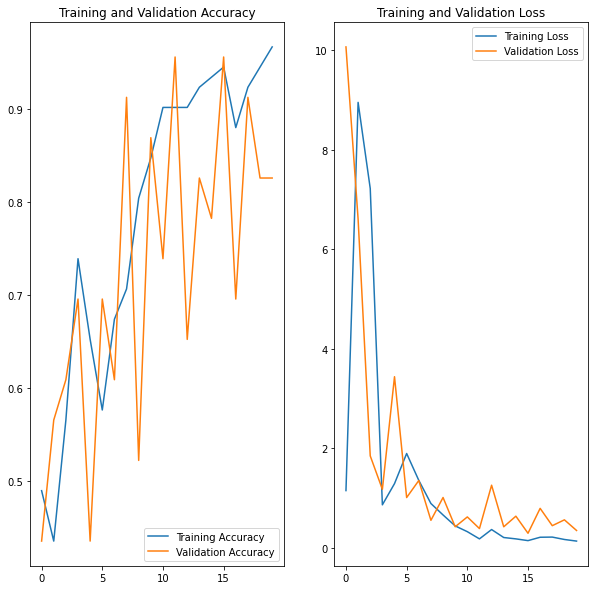

In [670]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#SUMMARY

###Training data accuracy: 96%
###Validation data accuracy: 82%

> In this model, I built a deep learning model using pretrained model to improve the model performance.
>The model can be improved by manipulating the data augumentation values and increasing the epoch number.
